In [1]:
import jieba
import jieba.posseg as pseg
import os
import re
from collections import defaultdict
from collections import Counter
from tqdm import tqdm
jieba.load_userdict('customdict.txt')
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'simhei'
plt.rcParams['axes.unicode_minus'] = False

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\lnxin\AppData\Local\Temp\jieba.cache
Loading model cost 0.613 seconds.
Prefix dict has been built successfully.


In [3]:
# 基础功能函数
def is_chinese_char(c):
    # 判断字符是否为汉字
    return '\u4e00' <= c <= '\u9fff'


def merge_aa(wordlist):
    # 扫描分词列表，将连续两个单字合并
    merged = []
    i = 0
    while i < len(wordlist):
        if (
            i < len(wordlist) - 1
            and len(wordlist[i]) == len(wordlist[i+1]) == 1
            and wordlist[i] == wordlist[i+1]
            and is_chinese_char(wordlist[i])
        ):
            merged.append(wordlist[i] + wordlist[i+1])
            i += 2
        else:
            merged.append(wordlist[i])
            i += 1
    return merged


def is_dup(word):
    # 接受词语，判断是否为叠词
    # 叠词种类：AA, AAB, ABB, AABB, ABAB, ABCC, LONG（多个单字词）
    stopwords = ['珊珊','亭亭',]
    if any(stop in word for stop in stopwords):  # 过滤掉一些人名（并不属于需要统计的叠词类型）
        return None
    n = len(word)
    aux = {'的', '地', '得', '着', '了'}  # 含一些助词的AA式叠词会被jieba分词为三字词，需要防止误判为AAB
    if n==2:
        if word[0]==word[1]:
            return 'AA'
    elif n==3:
        if (word[0]==word[1] and word[2] in aux):
            return 'AA'
        if (word[0]==word[1] and word[1] != word[2]):
            return 'AAB'
        elif (word[0]!=word[1] and word[1]==word[2]):
            return 'ABB'
    elif n==4:
        if (word[0]==word[1] and word[2]==word[3] and word[1]!=word[2]):
            return 'AABB'
        elif (word[0]==word[2] and word[1]==word[3] and word[0]!=word[1]):
            return 'ABAB'
        elif (word[0]!=word[1] and word[2]==word[3] and word[2] != word[0] and word[2] != word[1]):
            return 'ABCC'
        elif (word[0]==word[1] and word[2]!=word[3] and word[1] != word[2] and word[1] != word[3]):
            return 'AABC'
    elif n >= 3 and all(c == word[0] for c in word):
        return 'LONG'
    return None


def count_dup(wordlist):
    # 统计叠词。接受分词列表，返回叠词类型统计和叠词词典。
    word_dict = defaultdict(list)
    n = len(wordlist)
    # 词内叠词
    for i, word in enumerate(wordlist):
        result = is_dup(word)
        if result:
            word_dict[result].append(word)
    # 检测ABAB
    i=0
    while i < n-1:
        w1, w2 = wordlist[i], wordlist[i+1]
        if (len(w1)==2 and len(w2)==2 and w1==w2):
            abab_word = w1+w2
            word_dict['ABAB'].append(abab_word)
            i += 2
        else:
            i += 1
    return dict(word_dict)


def pie(data_dict:dict,author,suffix='.png'):
    # 接受叠词词典，绘制以作者为单位的叠词分布饼图
    color_map = {
        'AA': '#ff9999',
        'AAB': '#66b3ff',
        'ABB': '#99ff99',
        'AABB': '#ffcc99',
        'ABAB': '#c2c2f0',
        'AABC': '#ffb3e6',
        'ABCC': '#c2f0c2',
    }
    labels = [k for k in color_map if k in data_dict]
    sizes = [len(data_dict[k]) for k in labels]
    colors = [color_map[k] for k in labels]
    fname = f'{author}{suffix}'
    plt.figure(figsize=(10, 6))
    plt.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',  
        startangle=90,
        colors=colors
    )
    plt.title(f'{author}的叠词分布', fontsize=16)
    plt.tight_layout()
    plt.legend(loc="lower right",ncol=2)
    plt.savefig(fname, dpi=400)
    plt.show()


def clean_text(text):
    # 只保留汉字与标点符号。
    text = re.sub(r'[^\u4e00-\u9fff。，？、；：（）「」《》“”‘’——……]', '', text)
    return text


def seg(text):
    # 分词，返回词语列表
    return jieba.lcut(text)


def open_file(fname):
    # 接受文件名，返回清洗后的字符串
    with open(fname, "r",encoding = "utf-8", errors = "ignore") as f:
        text=f.read()
    return clean_text(text)


def write_file(result:dict, fname):
    # 将叠词处理结果写入文件
    with open(fname, 'w', encoding="utf-8", errors="ignore") as f:
        for cat,word in result.items():
            words = '、'.join(word)
            f.write(f'{cat}类叠词个数{len(word)}：{words}\n')

现在处理作者：萧红

作品《生死场》中：
AA类叠词个数345
AABB类叠词个数8
AAB类叠词个数7
ABB类叠词个数27
ABAB类叠词个数14
作品《呼兰河传》中：
ABB类叠词个数97
AABB类叠词个数53
AA类叠词个数557
ABCC类叠词个数7
AABC类叠词个数3
AAB类叠词个数20
ABAB类叠词个数54
作品《马伯乐》中：
AA类叠词个数1143
ABB类叠词个数126
AABB类叠词个数86
AAB类叠词个数6
AABC类叠词个数10
ABAB类叠词个数59
ABCC类叠词个数5
作品《小城三月》中：
AA类叠词个数179
ABB类叠词个数3
AABB类叠词个数2
ABAB类叠词个数5
AABC类叠词个数1
AAB类叠词个数1


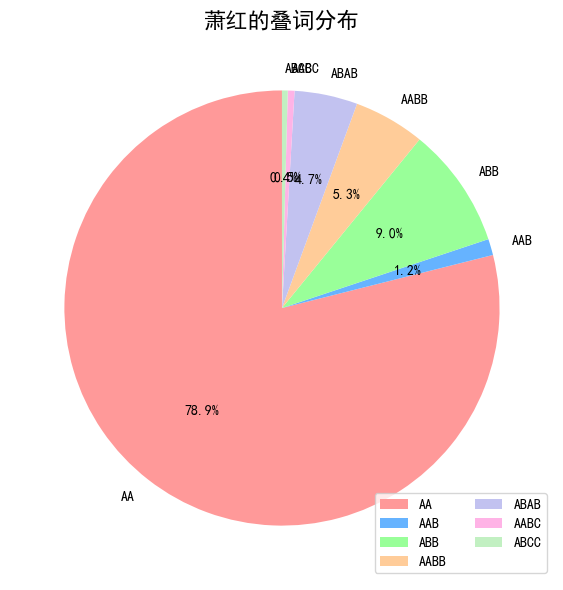

作者萧红的作品中：
AA类叠词个数2224
AABB类叠词个数149
AAB类叠词个数34
ABB类叠词个数253
ABAB类叠词个数132
ABCC类叠词个数12
AABC类叠词个数14
现在处理作者：丁玲

作品《韦护》中：
AA类叠词个数328
ABB类叠词个数26
AABB类叠词个数24
ABCC类叠词个数5
AAB类叠词个数3
ABAB类叠词个数7
作品《一九三零》中：
AA类叠词个数249
AAB类叠词个数3
AABB类叠词个数14
ABB类叠词个数10
ABCC类叠词个数2
ABAB类叠词个数11
作品《母亲》中：
AABB类叠词个数53
AAB类叠词个数23
AA类叠词个数695
ABB类叠词个数118
ABCC类叠词个数2
ABAB类叠词个数19
AABC类叠词个数4
作品《桑干河》中：
ABB类叠词个数80
AA类叠词个数889
AABB类叠词个数119
AABC类叠词个数12
AAB类叠词个数14
ABAB类叠词个数83
ABCC类叠词个数6


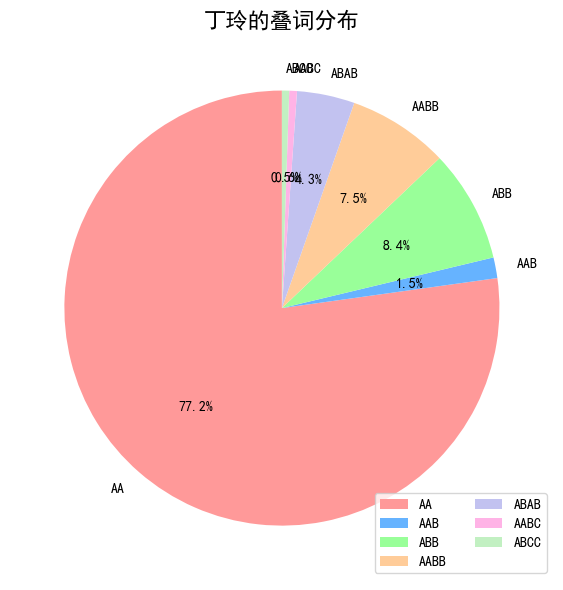

作者丁玲的作品中：
AA类叠词个数2161
ABB类叠词个数234
AABB类叠词个数210
ABCC类叠词个数15
AAB类叠词个数43
ABAB类叠词个数120
AABC类叠词个数16


In [5]:
# 在此指定需要分析的作者及作品
authors = {'萧红':['生死场.txt','呼兰河传.txt','马伯乐.txt','小城三月.txt'],
           '丁玲':['韦护.txt','一九三零.txt','母亲.txt','桑干河.txt']
}

def main():
    for author, files in authors.items():
        print(f'现在处理作者：{author}\n')
        author_words = defaultdict(list)
        for filename in files:
            try:
                with open(filename, 'r', encoding='utf-8') as f:
                    text = f.read()
                
                # 进行作品的统计
                try:
                    wordlist = list(seg(text))
                    merged = merge_aa(wordlist)
                    word_dict = count_dup(merged)  # word_dict是叠词字典，键为叠词类型
                    print(f'作品《{filename[:-4]}》中：')
                    for cat,word in word_dict.items():
                        print(f'{cat}类叠词个数{len(word)}')
                except Exception as e:
                    print(f'进行词语处理时出错：{e}')
                try:
                    write_file(word_dict, f'叠词统计_{filename[:-4]}.txt')
                except Exception as e:
                    print(f'未能成功写入文件：{e}')

                # 汇总到作者，便于后续统计
                for cat,word in word_dict.items():
                    author_words[cat].extend(word)
            except Exception as e:
                print(f'处理单个作品时出错：{e}')

        # 进行作者的统计
        try:
            write_file(author_words,f'叠词统计_{author}.txt')
            pie(author_words,author=author)
            print(f'作者{author}的作品中：')
            for cat,word in author_words.items():
                print(f'{cat}类叠词个数{len(word)}')
        except Exception as e:
            print(f'作者统计时出错：{e}')

main()